## AuxTel Mount fails - 18-Feb-21

In this notebook, investigate observed mount fails during the observing night 18-Feb-21

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time, TimeDelta
from lsst_efd_client import EfdClient
from lsst.daf.persistence import Butler

In [2]:
# Get EFD client and bring in Lupton's unpacking code
# This unpacks the 100 readings per second data into an ordered pandas Dataframe
client = EfdClient('summit_efd')

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

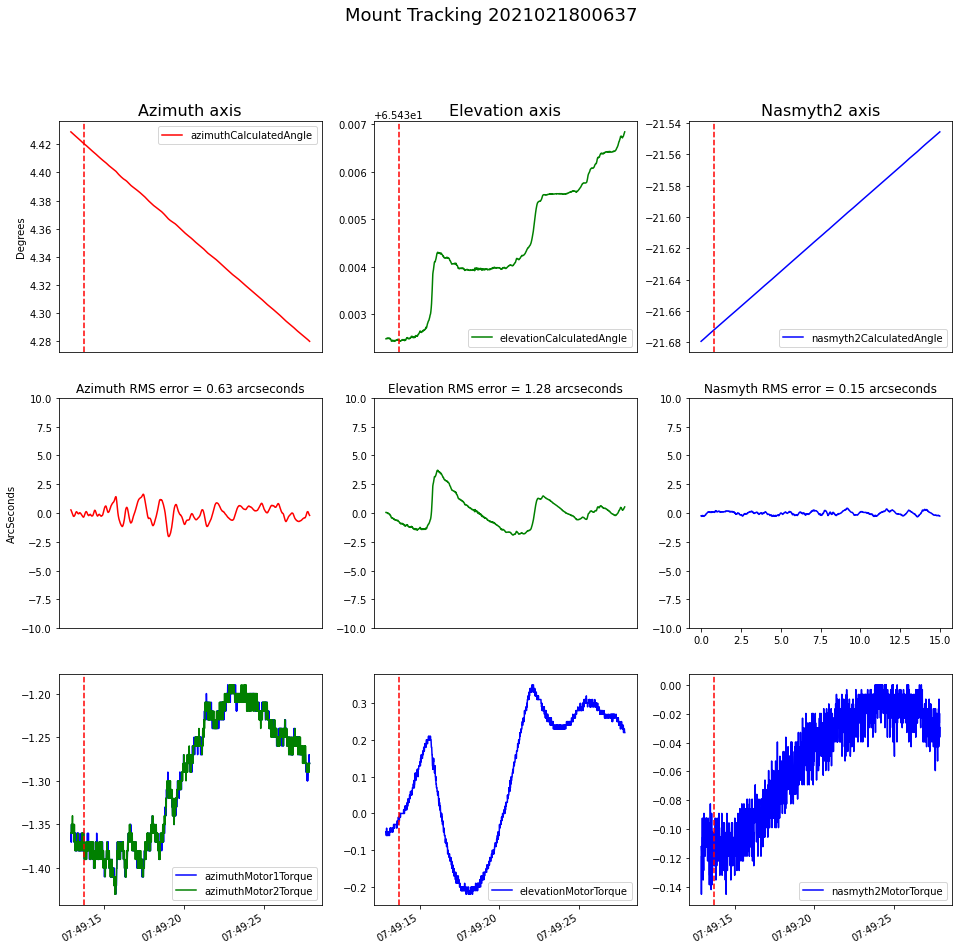

In [4]:
# Find the time of exposure
REPO_DIR = '/readonly/lsstdata/auxtel/base/auxtel/oods/butler/repo'
butler = Butler('/project/shared/auxTel/rerun/quickLook')
expId=2021021800637
exp = butler.get('raw', detector=0, expId=expId)
mData = exp.getMetadata()
tStart = mData['DATE-BEG']
tEnd = mData['DATE-END']
tDate = mData['DATE']

# Get the data
t_start = Time(tStart, scale='tai')
t_end = Time(tEnd, scale='tai')

mount_position = await client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", ['*'],
                                          t_start, t_end)
nasmyth_position = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", ['*'],
                                          t_start, t_end)
torques = await client.select_time_series("lsst.sal.ATMCS.measuredTorque", ['*'],
                                          t_start, t_end)

az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1)
el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1)
rot = merge_packed_time_series(nasmyth_position, 'nasmyth2CalculatedAngle', stride=1) 
az_torque_1 =  merge_packed_time_series(torques, 'azimuthMotor1Torque', stride=1)
az_torque_2 =  merge_packed_time_series(torques, 'azimuthMotor2Torque', stride=1)
el_torque =  merge_packed_time_series(torques, 'elevationMotorTorque', stride=1)
rot_torque =  merge_packed_time_series(torques, 'nasmyth2MotorTorque', stride=1)

# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
rot_vals = np.array(rot.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quadratic
az_fit = np.polyfit(times, az_vals, 2)
el_fit = np.polyfit(times, el_vals, 2)
rot_fit = np.polyfit(times, rot_vals, 2)

az_model = az_fit[0] * times * times + az_fit[1] * times + az_fit[2]
el_model = el_fit[0] * times * times + el_fit[1] * times + el_fit[2]
rot_model = rot_fit[0] * times * times + rot_fit[1] * times + rot_fit[2]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600
rot_error = (rot_vals - rot_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))
rot_rms = np.sqrt(np.mean(rot_error * rot_error))

# Plot it
fig = plt.figure(figsize = (16,16))
plt.suptitle(f"Mount Tracking {expId}", fontsize = 18)
# Azimuth axis
plt.subplot(3,3,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_title("Azimuth axis", fontsize=16)
ax1.axvline(tStart, color="red", linestyle="--")
ax1.set_xticks([])
ax1.set_ylabel("Degrees")
plt.subplot(3,3,4)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(3,3,7)
ax7 = az_torque_1['azimuthMotor1Torque'].plot(legend=True, color='blue')
ax7 = az_torque_2['azimuthMotor2Torque'].plot(legend=True, color='green')
ax7.axvline(tStart, color="red", linestyle="--")

# Elevation axis
plt.subplot(3,3,2)
ax2 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax2.set_title("Elevation axis", fontsize=16)
ax2.axvline(tStart, color="red", linestyle="--")
ax2.set_xticks([])
plt.subplot(3,3,5)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.subplot(3,3,8)
ax8 = el_torque['elevationMotorTorque'].plot(legend=True, color='blue')
ax8.axvline(tStart, color="red", linestyle="--")

# Nasmyth2 rotator axis
plt.subplot(3,3,3)
ax3 = rot['nasmyth2CalculatedAngle'].plot(legend=True, color='blue')
ax3.set_title("Nasmyth2 axis", fontsize=16)
ax3.axvline(tStart, color="red", linestyle="--")
ax3.set_xticks([])
plt.subplot(3,3,6)
plt.plot(times, rot_error, color='blue')
plt.title(f"Nasmyth RMS error = {rot_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.subplot(3,3,9)
ax9 = rot_torque['nasmyth2MotorTorque'].plot(legend=True, color='blue')
ax9.axvline(tStart, color="red", linestyle="--")

#plt.savefig(f"/home/craiglagegit/DATA/Mount_Errors_{expId}_20Feb21.pdf")
